## Installation 

In [2]:
#pip install torch
# pip install torchvision
# pip install seaborn 
# and others if not already installed...

In [3]:
import torch # version 1.3.1
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR

import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

import os

import cv2

import matplotlib.pylab as plt

# data augmentation
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# remove if not needed because augmentation is already applied 
from sklearn.utils.class_weight import compute_class_weight

import re

import random

import time
import copy

# INSTALL tqdm for jupyter lab:
# 1. pip install tqdm==4.36.1
# 2. pip install ipywidgets
# 3. jupyter nbextension enable --py widgetsnbextension
# 4. jupyter labextension install @jupyter-widgets/jupyterlab-manager (installed nodejs and npm needed)
from tqdm import tqdm_notebook as tqdm

import pandas as pd

import numpy as np

import seaborn as sns
sns.set()

In [4]:
from os import listdir
from glob import glob

## How is the original data structured?

In [8]:
patients = listdir('data/breast-histopathology-images/IDC_regular_ps50_idx5/')
noPatients = len(patients)  # 279 patients in total -> not a lot -> overfitting likely
print("Number of total patients in data set: " + str(noPatients))
print("sample patient ids: " + str(patients[190:200]))  # patients have 4-to-5-digit ids

Number of total patients in data set: 279
sample patient ids: ['12897', '9173', '9041', '10288', '12748', '8864', '12868', '13459', '16896', '9078']


In [12]:
twoClasses = listdir('data/breast-histopathology-images/IDC_regular_ps50_idx5/8864')
print(twoClasses)
print("--> 2 folders per patient: one for benign (0), the other for malign patches(1)")

['0', '1']
--> 2 folders per patient: one for benign (0), the other for malign patches(1)


In [24]:
imgFileNames0 = listdir('data/breast-histopathology-images/IDC_regular_ps50_idx5/8864/0')[:3]
print("sample image names for class 0: \n" + str(imgFileNames0))
print()
imgFileNames1 = listdir('data/breast-histopathology-images/IDC_regular_ps50_idx5/8864/1')[:3]
print("sample image names for class 1: \n" + str(imgFileNames1))

sample image names for class 0: 
['8864_idx5_x2701_y2401_class0.png', '8864_idx5_x2751_y2451_class0.png', '8864_idx5_x2151_y1001_class0.png']

sample image names for class 1: 
['8864_idx5_x1851_y2051_class1.png', '8864_idx5_x1651_y2701_class1.png', '8864_idx5_x2351_y2651_class1.png']


In [25]:
allImagePatches = glob('data/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
print("sample full paths to images: ")
for filename in allImagePatches[150000:150005]:
    print(filename)

sample full paths to images: 
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x1001_y351_class1.png
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x751_y201_class1.png
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x1701_y851_class1.png
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x1451_y501_class1.png
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x951_y851_class1.png


In [26]:
noAllPatches = len(allImagePatches)
print("total number of original images: " + str(noAllPatches))  # 277524

total number of original images: 277524


## Data visualisation

In [28]:
# read in 2 randomly selected example image patches
image_class0 = cv2.imread('data/breast-histopathology-images/IDC_regular_ps50_idx5/12905/0/12905_idx5_x1201_y2301_class0.png')
image_class1 = cv2.imread('data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x1701_y851_class1.png')

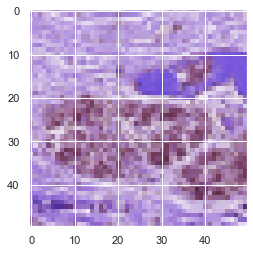

In [35]:
# show patch from class 0
plt.imshow(image_class0)

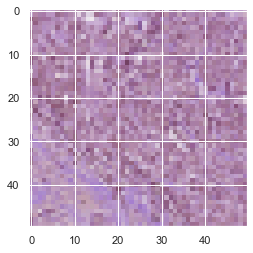

In [36]:
# show patch from class 1
plt.imshow(image_class1)

### Try different colour modes

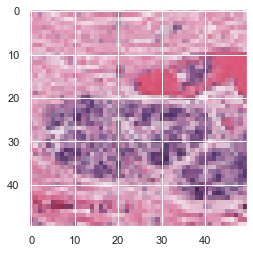

In [37]:
plt.imshow(cv2.cvtColor(image_class0, cv2.COLOR_BGR2RGB))

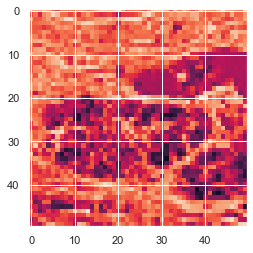

In [38]:
plt.imshow(cv2.cvtColor(image_class0, cv2.COLOR_BGR2GRAY))

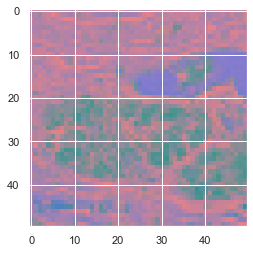

In [39]:
# color scheme used in paper
plt.imshow(cv2.cvtColor(image_class0, cv2.COLOR_BGR2YUV))

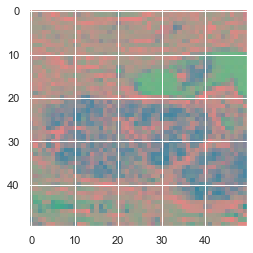

In [41]:
plt.imshow(cv2.cvtColor(image_class0, cv2.COLOR_RGB2YUV))

### Plot 64 tissue patches from both classes (randomly selected)

In [42]:
def plotTissuePatches(imagesForPlot):
    i_ = 0
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    random.shuffle(imagesForPlot)
    for image in imagesForPlot[8459:8523]:
        title = ""
        if "class0" in image:
            title = "0"
        else:
            title = "1"
        im = cv2.imread(image)   
        plt.subplot(8, 8, i_+1).set_title(title)
        plt.imshow(im); plt.axis('off')
        i_ += 1

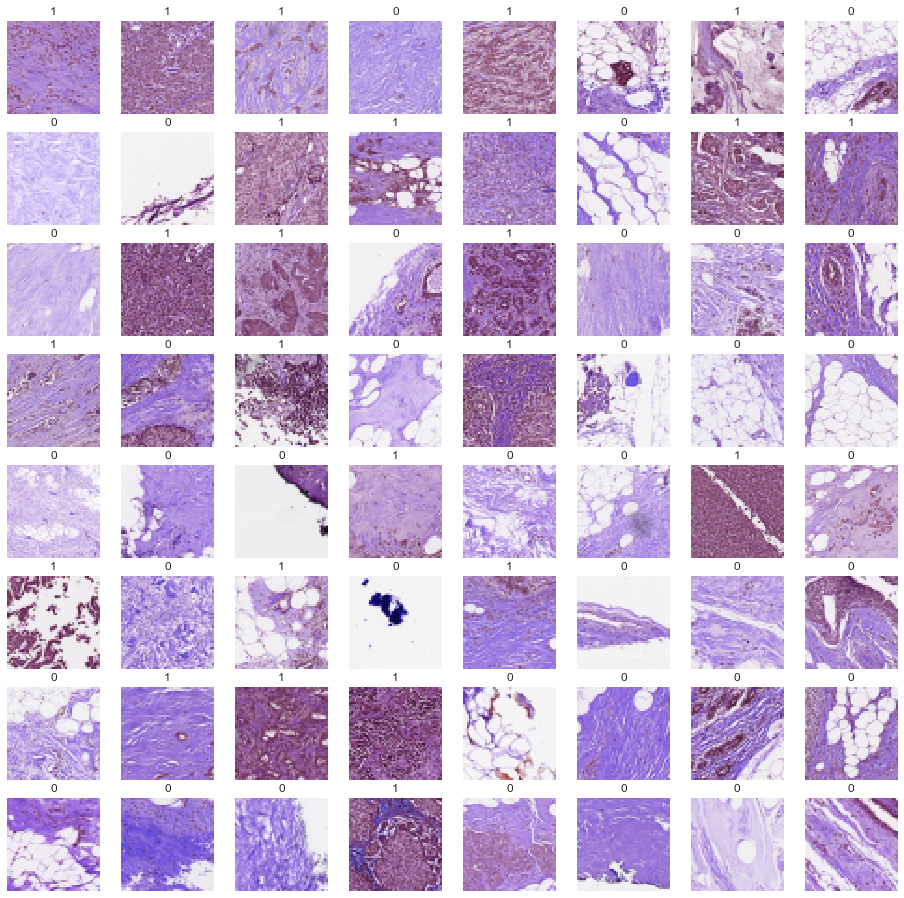

In [44]:
plotTissuePatches(allImagePatches)

## Create data frame

#### <font color='red'>Skip next 3 cells and continue at "Load data frame here"!</font>

In [51]:
# create empty data frame
data = pd.DataFrame(index=np.arange(0, noAllPatches), columns=["patient_id", "image_path", "label"])

# define base path
basePath = "data/breast-histopathology-images/IDC_regular_ps50_idx5/"

# fill data frame
def fillDataFrame(df, path, patients):
    i = 0
    for j in range(len(patients)):
        patientId = patients[j]
        patientPath = path + str(patientId)
        for label in [0,1]:
            classPath = patientPath + "/" + str(label) + "/"
            subfiles = listdir(classPath)
            for k in range(len(subfiles)):
                imagePath = subfiles[k]
                df.iloc[i]["image_path"] = classPath + imagePath
                df.iloc[i]["label"] = label
                df.iloc[i]["patient_id"] = patientId
                i += 1  
                
    return df

In [52]:
data = fillDataFrame(data, basePath, patients)
data

,patient_id,image_path,label
0,12905,data/breast-histopathology-images/IDC_regular_...,0
1,12905,data/breast-histopathology-images/IDC_regular_...,0
2,12905,data/breast-histopathology-images/IDC_regular_...,0
3,12905,data/breast-histopathology-images/IDC_regular_...,0
4,12905,data/breast-histopathology-images/IDC_regular_...,0
...,...,...,...
277519,9135,data/breast-histopathology-images/IDC_regular_...,1
277520,9135,data/breast-histopathology-images/IDC_regular_...,1
277521,9135,data/breast-histopathology-images/IDC_regular_...,1
277522,9135,data/breast-histopathology-images/IDC_regular_...,1


In [69]:
# Save data frame to json
data.to_json("dataframes/dfWithPatientPathLabel.json")

#### Load data frame here:

In [53]:
# Load data frame from json
loaded_df = pd.read_json("dataframes/dfWithPatientPathLabel.json")

In [55]:
# Print shape of loaded data frame
loaded_df.shape # should be (277524, 3)

(277524, 3)

## Analyse data set

#### Plot statistics on data set

In [74]:
def plotStatistics(df): 
    
    fig, ax = plt.subplots(1,3,figsize=(24,6))

    # Number of patches per patient
    sns.distplot(df.groupby("patient_id").size(), ax=ax[0], color="Black", kde=False, bins=30)
    ax[0].set_xlabel("Number of patches")
    ax[0].set_ylabel("Absolute frequency");
    ax[0].set_title("Number of patches per patient");

    # Percentage of malign patches
    cancer_perc = df.groupby("patient_id").label.value_counts(1)
    sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Red", kde=False, bins=30)
    ax[1].set_title("How much of a tissue sample is diagnosed malign?")
    ax[1].set_ylabel("Absolute frequency")
    ax[1].set_xlabel("% of patches malign");

    # Total number of benign and malign patches
    sns.countplot(df.label, ax=ax[2]);
    ax[2].set_xlabel("benign (class 0) vs. malign (class 1)")
    ax[2].set_title("How many patches are labeled malign in total?");

    print()

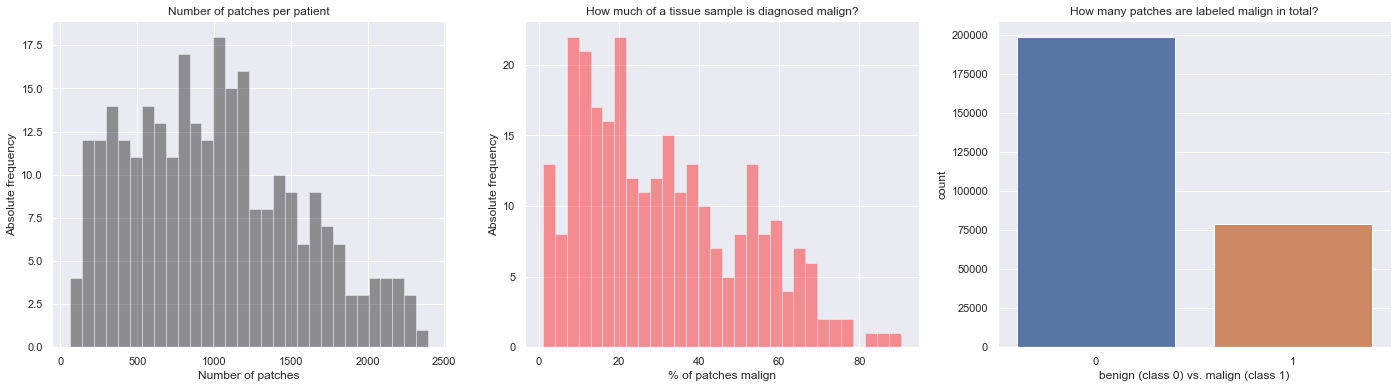

In [75]:
plotStatistics(loaded_df)

#### Extract coordinates from image patches ( for reconstruction of tissue sample as a whole)

In [145]:
# extract x and y coordinates of each patch in tissue sample images
def extractCoords(df):
    coord = df.image_path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

In [146]:
extractCoords(loaded_df)

,patient_id,image_path,label,x,y
0,10258,data/breast-histopathology-images/IDC_regular_...,0,801,1151
1,10258,data/breast-histopathology-images/IDC_regular_...,0,801,951
2,10258,data/breast-histopathology-images/IDC_regular_...,0,851,651
3,10258,data/breast-histopathology-images/IDC_regular_...,0,601,951
4,10258,data/breast-histopathology-images/IDC_regular_...,0,1001,851
...,...,...,...,...,...
277519,12891,data/breast-histopathology-images/IDC_regular_...,1,501,801
277520,12891,data/breast-histopathology-images/IDC_regular_...,1,551,701
277521,12891,data/breast-histopathology-images/IDC_regular_...,1,601,1051
277522,12891,data/breast-histopathology-images/IDC_regular_...,1,701,951


In [173]:
# TODO: visualize patches from coordinates

def getCancerDataframe(base_path, patient, label):
    path = base_path + str(patient) + "/" + label
    files = listdir(path)
    df = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + df.filename.values
    df = df.filename.str.rsplit("_", n=4, expand=True)
    df.loc[:, "label"] = np.int(label)
    df.loc[:, "image_path"] = path_names
    df = df.drop([0, 1, 4], axis=1)
    df = df.rename({2: "x", 3: "y"}, axis=1)
    df.loc[:, "x"] = df.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    df.loc[:, "y"] = df.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return df

def getPatientDataframe(patient, base_path):
    df_class0 = get_cancer_dataframe(base_path, patient, "0")
    df_class1 = get_cancer_dataframe(base_path, patient, "1")
    patient_df = pd.concat([df_class0, df_class1], axis = 0).reset_index(drop=True)
    return patient_df

In [137]:
#loaded_df.patient_id.values[0]

10258

In [174]:
d = getPatientDataframe(10258, basePath)

In [175]:
d.shape

(530, 4)

In [176]:
d

,x,y,label,image_path
0,801,1151,0,data/breast-histopathology-images/IDC_regular_...
1,801,951,0,data/breast-histopathology-images/IDC_regular_...
2,851,651,0,data/breast-histopathology-images/IDC_regular_...
3,601,951,0,data/breast-histopathology-images/IDC_regular_...
4,1001,851,0,data/breast-histopathology-images/IDC_regular_...
...,...,...,...,...
525,851,1051,1,data/breast-histopathology-images/IDC_regular_...
526,1451,1051,1,data/breast-histopathology-images/IDC_regular_...
527,1251,1101,1,data/breast-histopathology-images/IDC_regular_...
528,1251,1001,1,data/breast-histopathology-images/IDC_regular_...


In [177]:
# Plot randomly selected tissues from different patients
def plotSampleTissues(no_rows, no_cols, base_path):
    patients = list(loaded_df.patient_id.unique())
    no_patients = no_rows*no_cols
    patients = random.sample(patients, k=no_patients)
    fig, ax = plt.subplots(no_rows, no_cols, figsize=(20, 25))
    for i in range(no_rows):
        for j in range(no_cols):
            patient_id = patients[j + no_cols*i]
            example_df = getPatientDataframe(patient_id, base_path)

            ax[i,j].scatter(example_df.x.values, example_df.y.values, c=example_df.label.values, cmap="coolwarm", s=20);
            ax[i,j].set_title("patient " + str(patient_id))
            ax[i,j].set_xlabel("y coord")
            ax[i,j].set_ylabel("x coord")

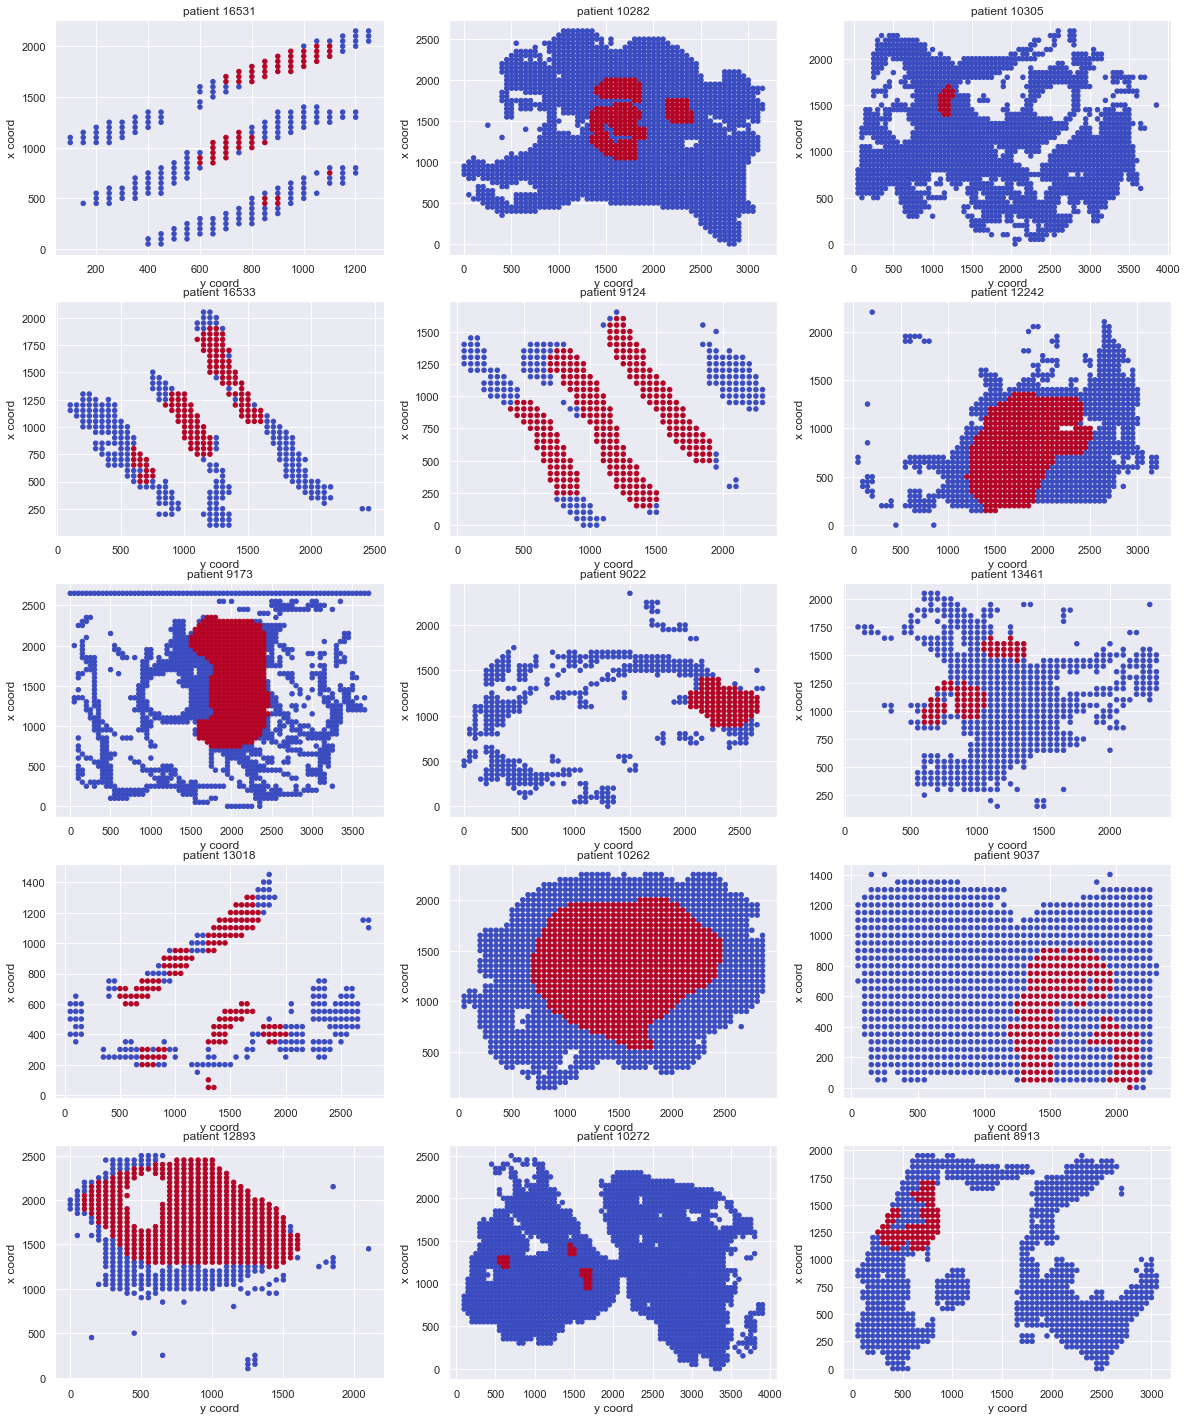

In [178]:
# plot 15 complete sample tissues
plotSampleTissues(5,3,basePath)

<b>The imbalanced class problem:</b>

In [29]:
size_class0 = len(loaded_df[loaded_df['label'] == 0]) #198.738
size_class1 = len(loaded_df[loaded_df['label'] == 1]) #78.786 -> class 1 is minority class

# print(size_class0, "vs.", size_class1, "-> difference of", size_class0 - size_class1)

In [30]:
size_class0/size_class1  # 2.52 -> class 0 is ~2.5 times larger than class 1!

2.522503998172264

In [31]:
loaded_df.groupby("label")["label"].count()

label
0    198738
1     78786
Name: label, dtype: int64

"Note that in medical imaging datasets, the split should always been done patient-level, meaning images of the same patient should either belong to the train or test set but not be shared among them." (https://mc.ai/skin-cancer-image-classification%E2%80%8A-%E2%80%8Aan-educational-guide/)

# Data split

- Training: ~ 72 % = 200 patients
- Validation: ~ 13/14 % = 39 patients
- Test: ~ 14 % = 40 patients
    
Split has to be made on patient level, not number of patches level (genauere Erkklärung einfügen)

In [32]:
# number of patches per patient (varying degree has to be ignored); nr of patients in total: 279
loaded_df.groupby("patient_id")["patient_id"].count()

patient_id
8863      979
8864     1133
8865      712
8867     1642
8913      955
         ... 
16568     828
16569     337
16570     917
16895     151
16896    1127
Name: patient_id, Length: 279, dtype: int64

In [33]:
#take unique patient_ids to split data patient-wise
patients = loaded_df.patient_id.unique()

#split patient_ids into training and test data:
train_ids, test_ids = train_test_split(patients, test_size=0.14, random_state=0)

#split training into train and validation sets:
final_train_ids, val_ids = train_test_split(train_ids, test_size=0.16, random_state=0)

print("Number of patients in training set: " + str(len(final_train_ids)))
print("Number of patients in validation set: " + str(len(val_ids)))
print("Number of patients in test set: " + str(len(test_ids)))

Number of patients in training set: 200
Number of patients in validation set: 39
Number of patients in test set: 40


In [34]:
val_ids

array([16533, 15515,  9178, 13694, 15514, 12907,  9081, 12868,  9181,
       13021, 13404, 14188, 10277, 10264, 10274,  8974,  9176, 12876,
       12824, 10286, 13617, 15516, 16550, 15510,  9126, 10259,  9255,
       16167, 10295, 12873,  8950,  9262, 13691, 10290,  9076, 10256,
       13023, 12910, 15473])

In [35]:
#new training set:
train_df = loaded_df.loc[loaded_df.patient_id.isin(final_train_ids),:].copy()

#new test data set:
test_df = loaded_df.loc[loaded_df.patient_id.isin(test_ids),:].copy()

#new validation data set:
val_df = loaded_df.loc[loaded_df.patient_id.isin(val_ids),:].copy()

#check whether right size of data:
#len(train_df.groupby("patient_id")["patient_id"].count())

## Check class distribution in newly divided datasets:

Text(0, 0.5, 'number of patients')

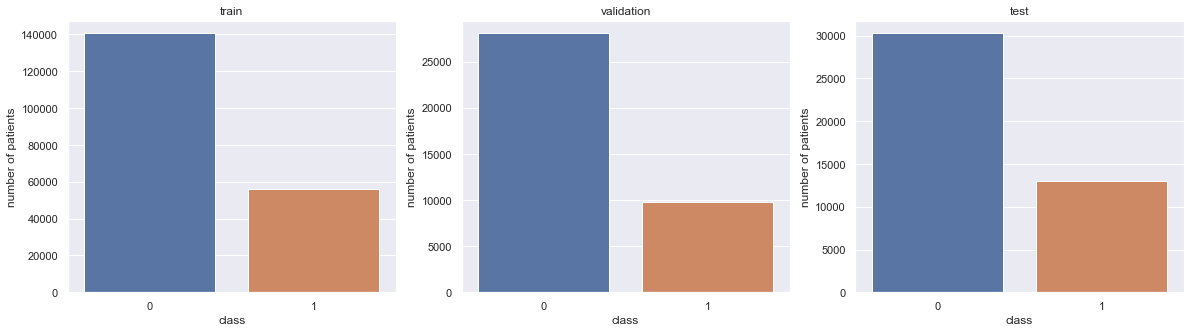

In [36]:
#visualization
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.label, ax=ax[0])
ax[0].set_title("train")
ax[0].set_xlabel("class")
ax[0].set_ylabel("number of patients")
sns.countplot(val_df.label, ax=ax[1])
ax[1].set_title("validation")
ax[1].set_xlabel("class")
ax[1].set_ylabel("number of patients")
sns.countplot(test_df.label, ax=ax[2])
ax[2].set_title("test")
ax[2].set_xlabel("class")
ax[2].set_ylabel("number of patients")

In [37]:
#class distribution in training set:
train_class0 = len(train_df[train_df['label'] == 0]) #140.416
train_class1 = len(train_df[train_df['label'] == 1]) #55.909

print("Class distribution in training set")
print("class0: " + str(train_class0))
print("class1: " + str(train_class1))

Class distribution in training set
class0: 140416
class1: 55909


In [38]:
#class distribution in validation set:
val_class0 = len(val_df[val_df['label'] == 0]) #28.057
val_class1 = len(val_df[val_df['label'] == 1]) #9.829

print("Class distribution in validation set")
print("class0: " + str(val_class0))
print("class1: " + str(val_class1))

Class distribution in validation set
class0: 28057
class1: 9829


In [39]:
#class distribution in test set:
test_class0 = len(test_df[test_df['label'] == 0]) #30.265
test_class1 = len(test_df[test_df['label'] == 1]) #13.048

print("Class distribution in test set")
print("class0: " + str(test_class0))
print("class1: " + str(test_class1))

Class distribution in test set
class0: 30265
class1: 13048


## Data augmentation

In the following section we will test data augmentation on the training set to boost the number of image patches with class 1 as it is much smaller than the patches in class 0 to reach an equal size. 

In the first section we will do some "manual" augmentation and visualize the results to get an idea of what is happening. We will perform image rotation and flipping for an original image patch.


In [40]:
#example patch:
imagePath_for_Aug = loaded_df.loc[0]['image_path']
imageClass = loaded_df.loc[0]['label']

In [41]:
#TO DO: In the research paper they use 'YUV' as color_mode. Leads to problems with cv2.imread as
# it needs RGB/ BGR as color mode apparently (error, no visulaization possible)
# But does it make more sense to use YUV?

#note: resizing the patch is not necessary (50x50 good choice already)
def preprocess_patch(image_path, color_mode):
    patch = cv2.imread(image_path)
    img_as_arr = Image.fromarray(patch, color_mode) #color_mode kann auch weggelassen werden; YUV nehmen??
    return img_as_arr  

In [42]:
#rotate and mirror a single image patch:
#this function also adds labels so the original image and the augmented onces can be visualized with labels
def augment_patch(image):
    augmented_images = []
    aug_labels = []
    
    #add original patch first for visualization purpose?
    augmented_images.append(image)
    aug_labels.append('original')
    
    #rotate original patch:
    rotation_angles = [90, 180, 270]
    for angle in rotation_angles:
        rotated_img = image.rotate(angle)
        augmented_images.append(rotated_img)
        aug_labels.append(angle)

    #mirror the patch:
    mirrored_img = ImageOps.mirror(image)
    augmented_images.append(mirrored_img)
    aug_labels.append('mirrored')
    
    return augmented_images, aug_labels    

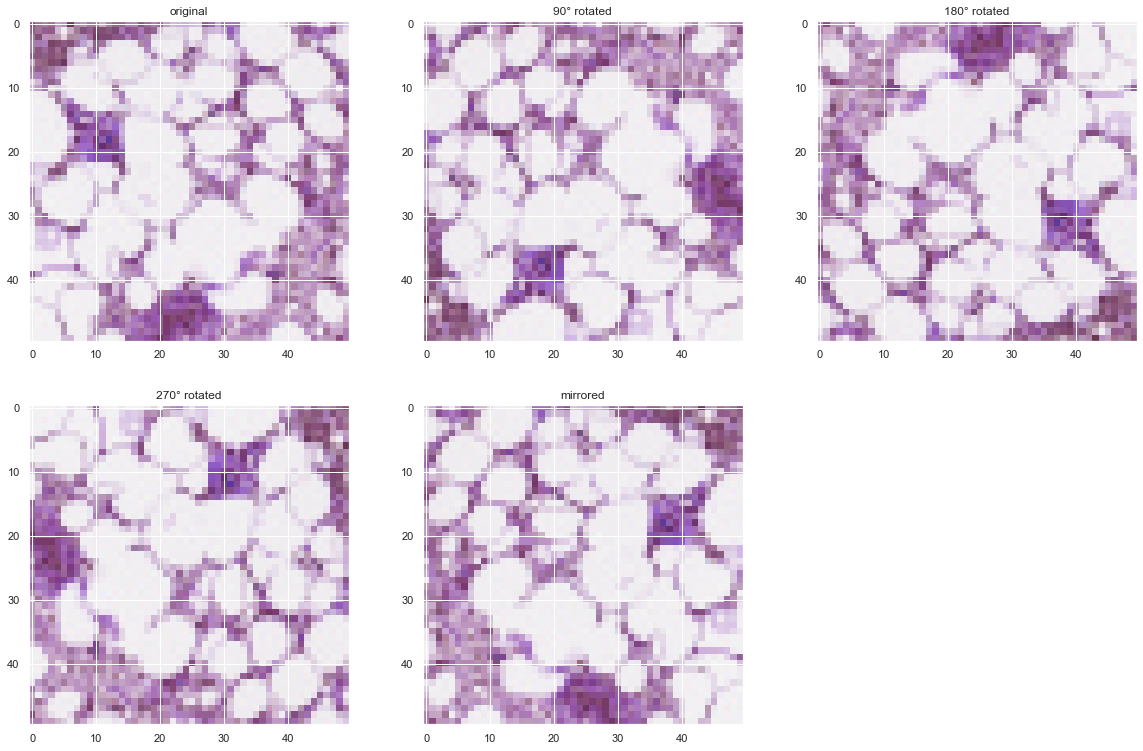

In [37]:
#visualization for the one example patch:

img_for_aug = preprocess_patch(imagePath_for_Aug, color_mode='RGB')
augmented_img, auglabels = augment_patch(img_for_aug)

plt.figure(1, figsize=(20,20))
n = 1
for img in augmented_img:
    plt.subplot(3,3,n)
    plt.imshow(img)
    if(isinstance(auglabels[n-1], int)):
        plt.title(str(auglabels[n-1]) + "° rotated")
    else:
        plt.title(auglabels[n-1])
    n +=1
    
plt.show()

In [43]:
#this function will be used for our image augmentation. 
# We decided to generate only two augmentations as we only want to achieve an equal number of patches in
# class 0 and 1. For that purpose we don't need more augmented pictures than two to fill up class 1

def final_augment_patch(image):
    augmented_images = []
    
    #augment patch randomly (choose between 3 rotation options or mirroring randomly):
    augmentation_options = [90, 180, 270, 'mirror']
    
    for index in range(2):
        rand = random.randint(0,3)
        chosen_aug = augmentation_options[rand]

        if(isinstance(chosen_aug, int)):
            augmented_img = image.rotate(chosen_aug)
            augmented_images.append(augmented_img)
        else:
            augmented_img = ImageOps.mirror(image)
            augmented_images.append(augmented_img)
    
    return augmented_images

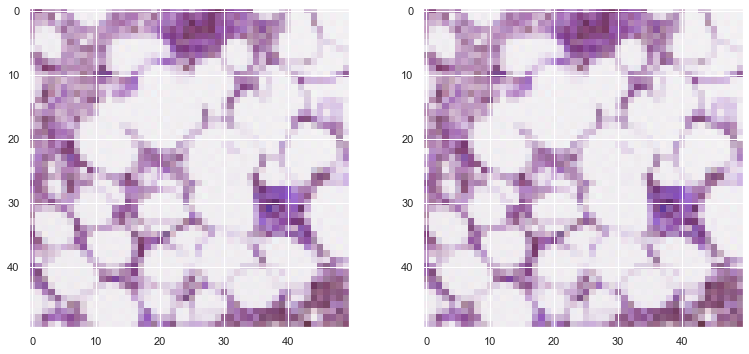

In [40]:
#example for one picture:
img_for_aug2 = preprocess_patch(imagePath_for_Aug, color_mode='RGB')
augmented_img2 = final_augment_patch(img_for_aug2)

plt.figure(1, figsize=(20,20))
n = 1
for img in augmented_img2:
    plt.subplot(3,3,n)
    plt.imshow(img)

    n +=1
    
plt.show()

## Final augmentation to boost the number of patches in the training set with class1

Decision: augment each patch from the smaller class 1 two times and choose as many patches from the newly created patches as we need to have an even distribution among both classes

In [44]:
os.listdir("data/train_class1_augmented/")
filepath = 'data/train_class1_augmented/'

In [45]:
#divide training data by label: 
train_df_class1 = train_df[train_df['label'] == 1] # 55.909
train_df_class0 = train_df[train_df['label'] == 0] # 140.416

In [46]:
train_df_class1

,patient_id,image_path,label,x,y
422,10258,data/breast-histopathology-images/IDC_regular_...,1,801,1101
423,10258,data/breast-histopathology-images/IDC_regular_...,1,1451,1151
424,10258,data/breast-histopathology-images/IDC_regular_...,1,951,751
425,10258,data/breast-histopathology-images/IDC_regular_...,1,1351,1101
426,10258,data/breast-histopathology-images/IDC_regular_...,1,1051,1001
...,...,...,...,...,...
277519,12891,data/breast-histopathology-images/IDC_regular_...,1,501,801
277520,12891,data/breast-histopathology-images/IDC_regular_...,1,551,701
277521,12891,data/breast-histopathology-images/IDC_regular_...,1,601,1051
277522,12891,data/breast-histopathology-images/IDC_regular_...,1,701,951


In [57]:
#create augmented image patches and save them to a new folder (only for class 1 from train_df)
filepath = 'data/train_class1_augmented/'

for index in range(len(train_df_class1)):
    img_path = train_df_class1.iloc[index]['image_path']
    new_filepath = (filepath + str(train_df_class1.iloc[index]['patient_id']) + '_idx5_x' + 
                    str(train_df_class1.iloc[index]['x']) + '_y' + str(train_df_class1.iloc[index]['y']) + 
                    '_class' + str(train_df_class1.iloc[index]['label']) + '_' + str(index))

    prep_img = preprocess_patch(img_path, color_mode='RGB')
    two_aug_imgs = final_augment_patch(prep_img)
    two_aug_imgs[0].save(new_filepath + 'a.png')
    two_aug_imgs[1].save(new_filepath + 'b.png')
    #augmented_train_class1.extend(two_aug_imgs)


### Load newly created augmented patches; final train_df creation

In [47]:
allAugPatches = glob(filepath + '/*.png', recursive=True)
nrAugPatches = len(allAugPatches)
nrAugPatches

111818

In [48]:
#create dataframe:
all_images = listdir(filepath)
aug_data = pd.DataFrame(all_images, columns=['image_name'])

aug_data

,image_name
0,12891_idx5_x1501_y1301_class1_55770b.png
1,16166_idx5_x1401_y1051_class1_10425a.png
2,9083_idx5_x1701_y701_class1_122b.png
3,10308_idx5_x1451_y1751_class1_2715b.png
4,9226_idx5_x1251_y2151_class1_49264b.png
...,...
111813,12818_idx5_x2401_y1301_class1_35397b.png
111814,8956_idx5_x1001_y301_class1_17554a.png
111815,14189_idx5_x1951_y1701_class1_15500a.png
111816,13693_idx5_x851_y1851_class1_38101b.png


In [49]:
#create new columns for the dataframe:

def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    
    return target

def create_image_path(x):
    return filepath + x

# create a new column called 'patient_id'
aug_data['patient_id'] = aug_data['image_name'].apply(extract_patient_id)
#create a new column called 'image_path'
aug_data['image_path'] = aug_data['image_name'].apply(create_image_path)
# create a new column called 'target'
aug_data['label'] = aug_data['image_name'].apply(extract_target)

#drop column 'image_name'
aug_data = aug_data.drop(['image_name'], axis=1)

In [50]:
aug_data

,patient_id,image_path,label
0,12891,data/train_class1_augmented/12891_idx5_x1501_y...,1
1,16166,data/train_class1_augmented/16166_idx5_x1401_y...,1
2,9083,data/train_class1_augmented/9083_idx5_x1701_y7...,1
3,10308,data/train_class1_augmented/10308_idx5_x1451_y...,1
4,9226,data/train_class1_augmented/9226_idx5_x1251_y2...,1
...,...,...,...
111813,12818,data/train_class1_augmented/12818_idx5_x2401_y...,1
111814,8956,data/train_class1_augmented/8956_idx5_x1001_y3...,1
111815,14189,data/train_class1_augmented/14189_idx5_x1951_y...,1
111816,13693,data/train_class1_augmented/13693_idx5_x851_y1...,1


In [51]:
#extract coords for augmented_dataframe:
def extract_coords_for_aug_data(df):
    coord = df.image_path.str.rsplit("_", n=5, expand=True)
    coord = coord.drop([0, 1, 4, 5], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

In [52]:
#all augmented data (all class 1):
aug_data_with_coords = extract_coords_for_aug_data(aug_data)
nr_augmented_data = len(aug_data_with_coords)

len_train_class0 = len(train_df_class0)
len_train_class1 = len(train_df_class1)

nr_missing_patches_for_class1 = len_train_class0 - len_train_class1

print("Number of newly augmented data from train set (class 1 only): " + str(nr_augmented_data))
print("Original number of patches in class 1: " + str(len_train_class1))
print("Wanted number for each class in training set: " + str(len_train_class0))
print("Nr of patches we will take from augmented data to fill up class 1: " + str(nr_missing_patches_for_class1))

Number of newly augmented data from train set (class 1 only): 111818
Original number of patches in class 1: 55909
Wanted number for each class in training set: 140416
Nr of patches we will take from augmented data to fill up class 1: 84507


In [53]:
#take number patches from aug_data needed to fill up class 1 so it reaches the same size as train patches with class 0:
aug_samples = aug_data_with_coords.sample(n=nr_missing_patches_for_class1)
aug_samples

,patient_id,image_path,label,x,y
94680,8951,data/train_class1_augmented/8951_idx5_x1451_y7...,1,1451,701
21069,8863,data/train_class1_augmented/8863_idx5_x1501_y1...,1,1501,1551
87446,12948,data/train_class1_augmented/12948_idx5_x851_y8...,1,851,851
25089,10299,data/train_class1_augmented/10299_idx5_x1101_y...,1,1101,551
73491,9073,data/train_class1_augmented/9073_idx5_x1201_y8...,1,1201,801
...,...,...,...,...,...
8855,14191,data/train_class1_augmented/14191_idx5_x2251_y...,1,2251,1751
37800,10308,data/train_class1_augmented/10308_idx5_x1451_y...,1,1451,851
26399,12817,data/train_class1_augmented/12817_idx5_x1951_y...,1,1951,601
93803,10285,data/train_class1_augmented/10285_idx5_x1051_y...,1,1051,751


### Now, as we have the samples from the augmented data with class 1 we can add it together with the rest of the data from the training set to get our final training data set:

In [55]:
final_train_df = pd.concat([train_df, aug_samples], ignore_index=True)
train_size = len(final_train_df)
print("The size of our final training data set is: " + str(train_size))

The size of our final training data set is: 280832


### Save final_train_df, val_df and test_df to json:

In [61]:
final_train_df.to_json("dataframes/final_train_df.json")
val_df = extract_coords(val_df)
test_df = extract_coords(test_df)
val_df.to_json("dataframes/val_df.json")
test_df.to_json("dataframes/test_df.json")

### Load final_train_df, val_df, test_df here:

In [54]:
loaded_train_df = pd.read_json("dataframes/final_train_df.json")
loaded_val_df = pd.read_json("dataframes/val_df.json")
loaded_test_df = pd.read_json("dataframes/test_df.json")

# Setup CNN

In [ ]:
# directory cnn_model has to be created
# execute <os.mkdir("cnn_model")> only once

In [71]:
BATCH_SIZE = 32
NUM_CLASSES = 2

OUTPUT_PATH = ""
MODEL_PATH = "cnn_model/"
LOSSES_PATH = "cnn_model/"

run_training = True
retrain = False

### Batch Normalization (für tatsächliches Training relevant)

In [72]:
#TODO normalisierung nachvollziehen
# note: resize weggelassen, weil schon in größe 50x50

def my_transform(key="train_transform"):
    #boost class 1 in training set:
    train_transform = [transforms.Resize((50, 50)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    
    val_test_transform = [transforms.Resize((50, 50)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        
    data_transforms = {'train_transform': transforms.Compose(train_transform), 
                       'val_test_transform': transforms.Compose(val_test_transform)}
    return data_transforms[key]

In [73]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.image_path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB') # try to convert to YUV instead of RGB later
        
        if self.transform:
            image = self.transform(image)
         
        label = np.int(self.states.label.values[idx])
        return {"image": image,
                "label": label,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [74]:
train_dataset = BreastCancerDataset(loaded_train_df, transform=my_transform(key="train_transform"))
val_dataset = BreastCancerDataset(loaded_val_df, transform=my_transform(key="val_test_transform"))
test_dataset = BreastCancerDataset(loaded_test_df, transform=my_transform(key="val_test_transform"))

In [75]:
image_datasets = {"train": train_dataset, "val": val_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}

## Dataloader

In [76]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [77]:
dataloaders = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [78]:
print(len(dataloaders["train"]), len(dataloaders["val"]), len(dataloaders["test"]))
# 8776 1183 1354 (due to batch-size of 32)
print("The numbers mean the following:")
print("Our training data set has a size of 280832 -- divided by the batch size of 32 this makes 8776 for train_dataloader.")

8776 1183 1354
The numbers mean the following:
Our training data set has a size of 280832 -- divided by the batch size of 32 this makes 8776 for train_dataloader.


## Model definition

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # cuda accelerates training on gpu
device

device(type='cpu')

In [99]:
# Download resnet18 model for pytorch: https://download.pytorch.org/models/resnet18-5c106cde.pth
# Save downloaded resnet18 model in directory cnn_model (created above)

In [80]:
model = torchvision.models.resnet18(pretrained=False)

if run_training:
    model.load_state_dict(torch.load("cnn_model/resnet18-5c106cde.pth"))

num_features = model.fc.in_features # 512. the number of inputs for the linear layer
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES)) 

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) # Xavier weight initialization
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


In [153]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [104]:
# no need for different class weights because of augmentation!?

#weights = compute_class_weight(y=loaded_train_df.label.values, class_weight="balanced", classes=loaded_train_df.label.unique())    
#class_weights = torch.FloatTensor(weights)
#if device.type=="cuda":
#    class_weights = class_weights.cuda()
#print(weights)

#print(device.type)
#print(device)

cpu


In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.3, momentum=0.9) # alternatively: Adam?!
scheduler = CyclicLR(optimizer, base_lr=0.05, max_lr=0.09) # what does the scheduler do??

In [82]:
def train_loop(model, criterion, optimizer, scheduler=None, num_epochs = 10, lam=0.0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_dict = {"train": [], "val": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)
    
    running_loss_dict = {"train": [], "val": [], "test": []}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ["train", "val", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
            
                        optimizer.step()
                        
                        
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    if scheduler is not None:
                        scheduler.step()
                
                counter += 1
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter*dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict, running_loss_dict

In [92]:
if run_training:
    model, loss_dict, running_loss_dict = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = 5)
    
    if device == "cpu":  
        OUTPUT_PATH += ".pth"
    else:
        OUTPUT_PATH += "_cuda.pth" # after first training this output path was chosen.. this is not correct. How come?
        
    torch.save(model.state_dict(), OUTPUT_PATH)
    
    losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
    losses_df.loc[:, "dev"] = loss_dict["val"] 
    losses_df.loc[:, "test"] = loss_dict["test"]
    losses_df.to_csv("losses_breastcancer.csv", index=False)
    
    running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
    running_losses_df.loc[0:len(running_loss_dict["val"])-1, "dev"] = running_loss_dict["dev"]
    running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
    running_losses_df.to_csv("running_losses_breastcancer.csv", index=False)
else:
    if device == "cpu":
        MODEL_PATH += ".pth"        
    else:
        MODEL_PATH += "_cuda.pth"
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    
    losses_df = pd.read_csv(LOSSES_PATH + "losses_breastcancer.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_breastcancer.csv")

Epoch 0/4
----------


/home/rosanna/Dokumente/neuronalenetze/brustkrebs_projekt/gitBreastCancer/BreastCancer/BreastCancerVEnv/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.3799 Acc: 0.8425



val Loss: 0.4324 Acc: 0.8090



test Loss: 0.4177 Acc: 0.8162

Epoch 1/4
----------



train Loss: 0.3382 Acc: 0.8566



val Loss: 0.3995 Acc: 0.8302



test Loss: 0.4021 Acc: 0.8267

Epoch 2/4
----------



train Loss: 0.3322 Acc: 0.8598



val Loss: 0.3780 Acc: 0.8364



test Loss: 0.3980 Acc: 0.8281

Epoch 3/4
----------



train Loss: 0.3291 Acc: 0.8613



val Loss: 0.3923 Acc: 0.8278



test Loss: 0.4032 Acc: 0.8248

Epoch 4/4
----------



train Loss: 0.3262 Acc: 0.8628



val Loss: 0.4271 Acc: 0.8116



test Loss: 0.4110 Acc: 0.8221

Training complete in 3294m 59s
Best val Acc: 0.000000


KeyError: 'dev'

In [141]:
# Evaluate the model on testing data
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
confusion_matrix_test = torch.zeros(2, 2)
with torch.no_grad():
    correct = 0
    total = 0
       
    for i, data in enumerate(dataloaders["test"]):
        images = data["image"].to(device)
        labels = data["label"].to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix_test[t.long(), p.long()] += 1
                 
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the test images: 63.06882460231339 %


In [152]:
# confusion_matrix_test123 = torch.zeros(2, 2)

#lab = [0,1,0,1,0,0,0]
#pre = [1,1,0,1,0,0,0]

#for t, p in zip(lab, pre):
#                confusion_matrix_test123[t, p] += 1
        
#print(confusion_matrix_test123)

In [145]:
# Evaluate the model on validation data
model.eval()  
confusion_matrix_val = torch.zeros(2, 2)
with torch.no_grad():
    correct = 0
    total = 0
       
    for i, data in enumerate(dataloaders["val"]):
        images = data["image"].to(device)
        labels = data["label"].to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
      #  proba = outputs.cpu().numpy().astype(np.float)
      #  print(proba)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix_val[t.long(), p.long()] += 1
                 
    print('Test Accuracy of the model on the validation images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model_val.ckpt')

Test Accuracy of the model on the validation images: 67.13334742180896 %


In [146]:
#for i, data in enumerate(dataloaders["val"]):
#        images = data["image"]
#        labels = data["label"]
       # print(images)
       # print(len(labels))
#        print(labels.size(0))
      #  print(labels.view)
      #  print(len(images))

[[26170.  4095.]
 [11901.  1147.]]


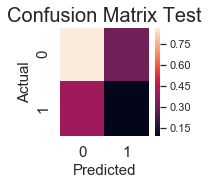

In [149]:
# Plot confusion matrix for test results with testing data set
cm_test = confusion_matrix_test.numpy()

print(cm_test)

fig,ax= plt.subplots(figsize=(2,2))
sns.heatmap(cm_test / (cm_test.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

ax.set_xlabel('Predicted', size=15);
ax.set_ylabel('Actual', size=15); 
ax.set_title('Confusion Matrix Test', size=20); 
ax.xaxis.set_ticklabels(['0','1'], size=15); 
ax.yaxis.set_ticklabels(['0',"1"], size=15);

[[24488.  3569.]
 [ 8873.   926.]]


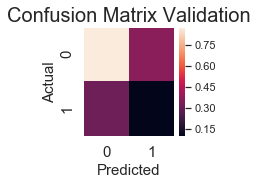

In [151]:
# Plot confusion matrix for test results with validation data set
cm_val = confusion_matrix_val.numpy()

print(cm_val)

fig,ax= plt.subplots(figsize=(2,2))
sns.heatmap(cm_val / (cm_val.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=15);
ax.set_ylabel('Actual', size=15); 
ax.set_title('Confusion Matrix Validation', size=20); 
ax.xaxis.set_ticklabels(['0','1'], size=15); 
ax.yaxis.set_ticklabels(['0',"1"], size=15);